# Análise da Eficácia e Generalização de Modelo de Regressão para Diferentes Tamanhos de Fibra Óptica

In [30]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power

In [2]:
import OpticFunctions as of
import importlib

In [41]:
importlib.reload(of)

<module 'OpticFunctions' from 'C:\\Users\\jezra\\Redes Neurais - Pytorch\\OpticFunctions.py'>

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
np.random.seed(seed=123)

## Fibra com 60 km

In [7]:
SpS = 16  # Amostras por símbolo
Mod_ord = 4              # Ordem do formato de modulação
Sr = 10e9          # taxa de símbolos

#Simulação do Sinal
sinalt_60, symbt_60 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [8]:
#Parâmetros do Canal
fibra_60 = 60
ruido = 4.5

sinalr_60 = of.SimulaCanalOptico(sinal = sinalt_60, Rs = Sr, SpS = SpS,  dist_fibra = fibra_60, ruido = ruido)

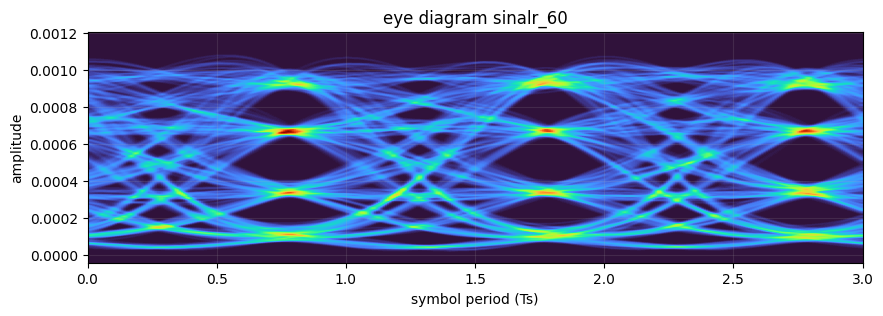

In [23]:
of.PlotEyediagram(sinalr_60, SpS, label = 'sinalr_60')

## Fibra com 80 km

In [9]:
sinalt_80, symbt_80 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [10]:
fibra_80 = 80

sinalr_80 = of.SimulaCanalOptico(sinal = sinalt_80, Rs = Sr, SpS = SpS, dist_fibra = fibra_80, ruido = ruido)

## Fibra com 100 km

In [11]:
sinalt_100, symbt_100 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [12]:
fibra_100 = 100

sinalr_100 = of.SimulaCanalOptico(sinal = sinalt_100, Rs = Sr, SpS = SpS, dist_fibra = fibra_100, ruido = ruido)

## Criação dos Conjuntos de Dados

Aqui o conjunto de dados para treinamento será composto por 80% dos sinais que foram transmitidos pelas fibras, e o conjunto de avaliação dos outros 20% de cada sinal.

Para avaliação do modelo em seguida, há trêns conjuntos de dados, cada um contendo um sinal isolado de um dos três canais 

In [13]:
from torch.utils.data import ConcatDataset

In [14]:
SpS_in = 16
Ntaps = 64
batch_size = 64
shuffle = False

train_dataset_60, test_dataset_60, full_dataset_60 = of.CriaDataSet(symb = symbt_60, signal = sinalr_60, SpS_in = SpS_in)
train_dataset_80, test_dataset_80, full_dataset_80 = of.CriaDataSet(symb = symbt_80, signal = sinalr_80, SpS_in = SpS_in)
train_dataset_100, test_dataset_100, full_dataset_100 = of.CriaDataSet(symb = symbt_100, signal = sinalr_100, SpS_in = SpS_in)

comb_train_ds = ConcatDataset([train_dataset_60, train_dataset_80, train_dataset_100])
comb_test_ds = ConcatDataset([test_dataset_60, test_dataset_80, test_dataset_100])

train_dataloader = DataLoader(comb_train_ds, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(comb_test_ds, batch_size=batch_size, shuffle=shuffle)

full_dataloader_60 = DataLoader(full_dataset_60, batch_size=batch_size, shuffle=shuffle)
full_dataloader_80 = DataLoader(full_dataset_80, batch_size = batch_size, shuffle = shuffle)
full_dataloader_100 = DataLoader(full_dataset_100, batch_size = batch_size, shuffle = shuffle)

## Criação do modelo

Aqui será definido um modelo de rede neural MLP, com 5 camadas lineares, e utilizando a função ReLU como camada oculta. Esse modelo tem uma complexidade moderada, mas apropriada para o tamanho dos conjuntos de dados utilizados


In [74]:
modelo = MLP([Ntaps, 16, 8, 4, 1])

### Definição dos Hiperparâmetros

In [75]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr = 0.0006)
epochs = 6
cada_print = 5000

In [76]:
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo, loss, optimizer, cada_print)
    of.test_loop(test_dataloader, modelo, loss)
print("Pronto!")

Época 1
-------------------------------
loss: 1.164189[   64/2400000]
loss: 0.000706[320064/2400000]
loss: 0.000451[640064/2400000]
loss: 0.000765[960064/2400000]
loss: 0.000983[1280064/2400000]
loss: 0.079351[1600064/2400000]
loss: 0.001762[1920064/2400000]
loss: 0.000332[2240064/2400000]
Perda média: 0.003790 

Época 2
-------------------------------
loss: 0.014742[   64/2400000]
loss: 0.000031[320064/2400000]
loss: 0.000108[640064/2400000]
loss: 0.000021[960064/2400000]
loss: 0.000040[1280064/2400000]
loss: 0.061107[1600064/2400000]
loss: 0.000083[1920064/2400000]
loss: 0.000036[2240064/2400000]
Perda média: 0.001363 

Época 3
-------------------------------
loss: 0.012664[   64/2400000]
loss: 0.000028[320064/2400000]
loss: 0.000005[640064/2400000]
loss: 0.000000[960064/2400000]
loss: 0.000000[1280064/2400000]
loss: 0.050012[1600064/2400000]
loss: 0.000030[1920064/2400000]
loss: 0.000011[2240064/2400000]
Perda média: 0.001380 

Época 4
-------------------------------
loss: 0.011395[

In [77]:
of.test_loop(full_dataloader_60, modelo, loss)
of.test_loop(full_dataloader_80, modelo, loss)
of.test_loop(full_dataloader_100, modelo, loss)

Perda média: 0.007451 

Perda média: 0.000641 

Perda média: 0.000131 



### Observações
Como não se pode analisar a eficácia do equalizador somente a partir da função de perda, vamos analisar a BER do sinal sem e com equalizador para a potência de entrada já estabelecida. Após isso, vamos fazer um teste mais rigoroso, para diferentes potências de entrada do sinal, utilizando uma fibra de 70 km.

Number of counted errors = 163 
BER = 8.15e-05 


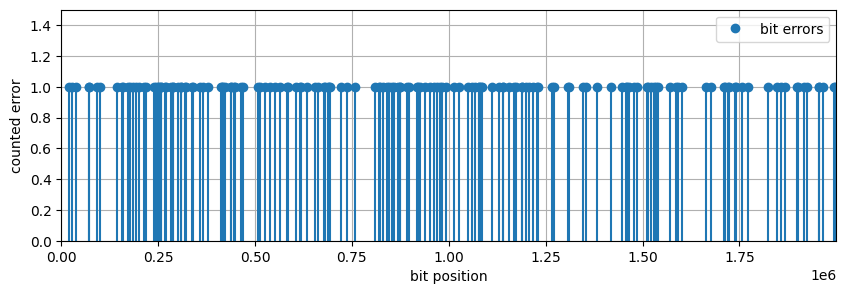

In [24]:
bitsr_80 = of.RecuperaBits(sinal = sinalr_80, SpS = SpS, M = Mod_ord)
bitst_80 = of.RecuperaBits(sinal = sinalt_80, SpS = SpS, M = Mod_ord)
#Calcula a taxa de erro entre os bits

of.CalculaBER(bitst_80, bitsr_80)

Number of counted errors = 1013 
BER = 5.07e-04 


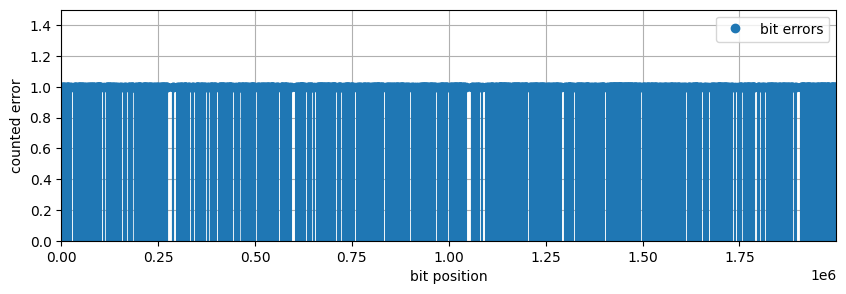

In [78]:
#symb_rx_nn = of.GeraSinalEqualizado(modelo, full_dataloader_60)
modelo.eval()
symbRx_NN_list = []  # inicializa uma lista vazia
with torch.no_grad():
    for batch, (X, y) in enumerate(full_dataloader_80):
        X = X.float()
        pred = modelo(X)

        # adiciona os símbolos preditos à lista
        symbRx_NN_list.append(pred.numpy().reshape(-1,))

# concatena todos os símbolos preditos em um único array NumPy
symbRx_NN = np.concatenate(symbRx_NN_list)
        

const = GrayMapping(Mod_ord, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bits_rx_nn = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbt_80), Mod_ord, 'pam')

of.CalculaBER(bitt, bits_rx_nn)

## Calculando a BER por Potência de Entrada

In [ ]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx70, symbtx70 = SimulaSinalOptico(SpS = SpS, Rs = Sr, M = Mod_ord, Pi_dBm = Pin)
    
    irx70 = SimulaCanalOptico(sinaltx70, SpS = SpS, Rs = Sr, dist_fibra = 70)
    
    bitsTx70 = of.RecuperaBits(sinaltx70)
    bitsRx70 = RecuperaBits(irx70)
    
    err = np.logical_xor(bitsRx70[discard:bitsRx70.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx70[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx70, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = model(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx.size-discard], bitsTx70[discard:bitsTx70.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))